# Fjerde ordens Runge-Kutta metode for drevet harmonisk pendel
## Numerisk prosjekt vår 2025
Håkon Støren og Vetle Støren

Som gitt i oppgaven har vi at 
\begin{equation*}
    \frac{\textrm{d}^2\theta}{\textrm{d}t^2} + q\frac{\textrm{d}\theta}{\textrm{d}t}+\frac{g}{l}\sin{(\theta)}=\frac{F_D}{ml}\sin{(\omega_D t)},
\end{equation*}
hvor
- $\theta$ er utslagsvinkelen til pendelen,
- $g$ er tyngdeakselerasjonen,
- $l$ er lengden av snora,
- $q$ er en friksjonsparamter,
- $\frac{F_D}{ml}$ er drivkraften som pendelen blir utsatt for,
- $\omega_D$ er drivkraftens vinkelfrekvens. \
Vi har også fra oppgaveteksten at
- $\omega_0 = \sqrt{g/l}$ og er pendelens vinkelfrekvens

Vi antar at $\sin{\theta}\approx\theta$

In [14]:
# Importerer alle bibliotekene vi trenger
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

In [15]:
# Initialiserer alle konstanter
l = 1                   # m, lengden av snora
g = 9.8                 # m/s^2, tyngdeakselerasjon
theta_0 = 0.2           # rad, initiell vinkel med hensyn til vertikalen
theta_dot_0 = 0         # rad/s, initiell vinkelhastighet
q = 1.0                 # s^-1, friksjonsparameter
w_D = 3.13              # rad/s, drivkraftens vinkelfrekvens
drivkraft = 0.2         # s^-2, F_D/(ml)
dt = 0.001              # s, tidssteg
T = 20                  # s, maksimal tid

# 1
I oppgaven er Runge-Kutta 4 implementert som i numerisk øving 3.
Plottet viser løsningen av bevegelsesligningen i løpet av 20 sekunder med dt = 0.01.
Den er løst ved å sette 
$$d\theta = \omega$$
og
$$d\omega = -q\omega-\frac{g}{l}\theta+F_d \sin{\omega_d t}.$$

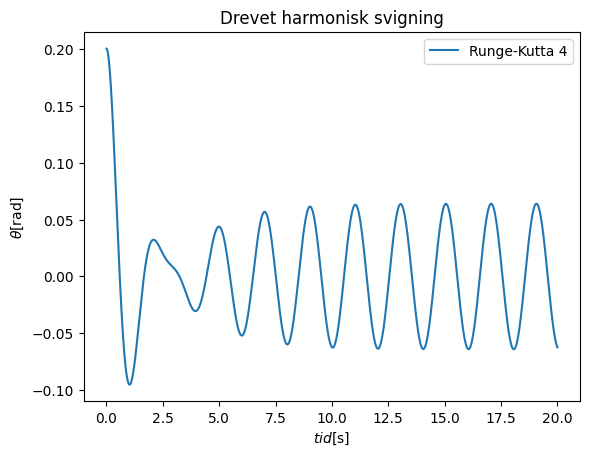

In [16]:
# 1
from typing import List

def equation(t: float, vals: List[float], params: List[float]):
    dw = -params[1]*vals[1]-g/l*vals[0]+params[2]*np.sin(params[0]*t)
    dtheta = vals[1]
    
    return np.array([dtheta, dw])

def RK4_step(RHS, vals, params, t, dt):
    """
    Calculates one step of the RK4-algorithm.
    
    RHS: (callable) function representing the right hand side of the differential equations
    vals: (numpy array) previous values of theta and omega, [theta, omega]
    params: (array) parameters of the equation, [w_d, q, F_d] 
    t: (float) previous time
    dt: (float) timestep
    
    return: (array) next values [theta_next, omega_next]
    """
    k1 = RHS(t, vals, params)
    k2 = RHS(t+dt/2, vals+(dt/2)*k1, params)
    k3 = RHS(t+dt/2, vals+(dt/2)*k2, params)
    k4 = RHS(t+dt, vals+dt*k3, params)
    return vals + (dt/6)*(k1 + (2*k2) + (2*k3) + k4)

def RK4_method(RHS, theta_0, theta_dot_0, w_d, q, F_d, dt, T):
    """
    Computes theta and w (omega).  
    
    Parameters
    -----------
    RHS: RHS of the differential equation 
    theta0: initial value of theta
    w0: initial value of omega
    dt: timestep
    T: max t
    
    return theta, w, t
    
    """
    
    steps = int(T/dt)
    theta = np.zeros(steps)
    theta[0] = theta_0
    w = np.zeros(steps)
    w[0] = theta_dot_0

    t = np.linspace(0, T, steps)

    for i in range(1,steps):
        theta[i], w[i] = RK4_step(RHS,[theta[i-1],w[i-1]], [w_d, q, F_d], t[i-1], dt)
    return theta, w, t


RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, w_D, q, drivkraft, dt, T)

plt.plot(RK4_t, RK4_theta, label="Runge-Kutta 4")
plt.title("Drevet harmonisk svigning")
plt.xlabel("$tid$[s]")
plt.ylabel("$\\theta$[rad]")

plt.legend()
plt.show()

# 2
Første delen av oppgaven er en implementasjon av Euler-Cromer som gjort i numerisk øving 3. 
Deretter ble en konvergenstest gjennomført for å finne den beste dt-verdien. Her ble forskjellen mellom energien for begynnelsen og slutten av simulasjonen plottet. Av de verdiene som ble testet ser vi at simuleringen blir veldig mye dårligere etter $dt\approx 0.01$ for begge simulasjonene. Det vil si at det er mulig å bruke $dt=0.01$, selv om mindre $dt$ vil gi mer stabilt resultat. Vi gjenkjenner at energien ikke er bevart, men til tross for dette kan konvergenstesten gi en indikasjon på hvor stabil simulasjonen er.

In [17]:
# 2 Euler-Cromer
def euler_cromer_approx(theta_0, theta_dot_0, dt, T):
    """
    Calculates angular displacement and angular velocity 
    using the Euler-Cromer method 
    """
    N = int(T/dt)
    t = np.linspace(0, T, N + 1)
    theta, w = np.zeros(N+1), np.zeros(N+1)
    theta[0], w[0] = theta_0, theta_dot_0
    for i in range(N):
        w[i+1] = w[i] +(-q*w[i]-g/l*theta[i]+drivkraft*np.sin(w_D*t[i]))*dt
        theta[i+1] = theta[i] + w[i+1]*dt
    return theta, w, t

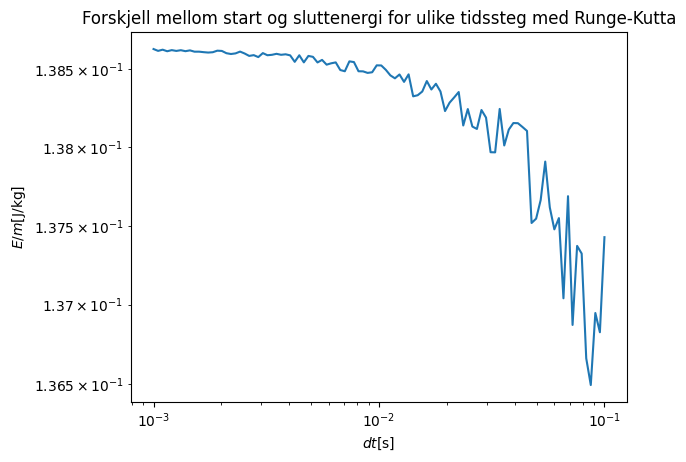

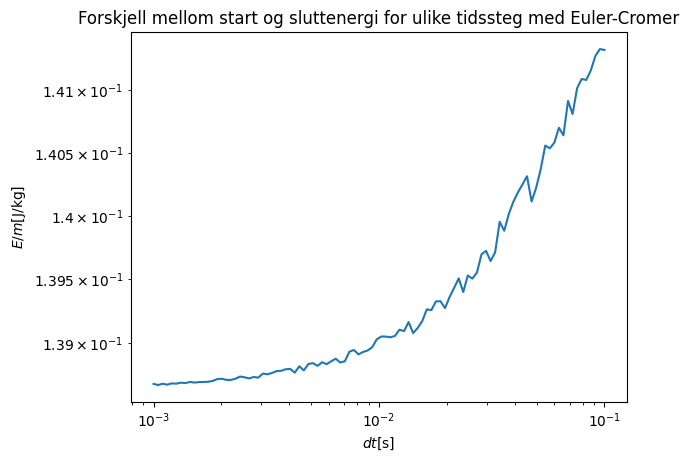

In [132]:
# 2 Konvergenstest

dts = np.logspace(-3, -1, 100)

def E_p(theta):
    return 0.5*g*l*theta**2
def E_k(w):
    return 0.5*l**2*w**2
def E(theta, w):
    return E_p(theta)+E_k(w)-drivkraft*l*theta-q*l*theta


RK4_energies = np.zeros(len(dts))
for i in range(len(dts)):
    RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, w_D, q, drivkraft, dts[i], T)
    RK4_energies[i] = np.abs(E(RK4_theta[0], RK4_w[0])-E(RK4_theta[-1], RK4_w[-1]))
plt.plot(dts, RK4_energies)
plt.title("Forskjell mellom start og sluttenergi for ulike tidssteg med Runge-Kutta")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$dt$[s]")
plt.ylabel("$E/m$[J/kg]")
plt.show()


EC_energies = np.zeros(len(dts))
for i in range(len(dts)):
    EC_theta, EC_w, EC_t = euler_cromer_approx(theta_0, theta_dot_0, dts[i], T)
    EC_energies[i] = np.abs(E(EC_theta[0], EC_w[0])-E(EC_theta[-1], EC_w[-1]))
plt.plot(dts, EC_energies)
plt.title("Forskjell mellom start og sluttenergi for ulike tidssteg med Euler-Cromer")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$dt$[s]")
plt.ylabel("$E/m$[J/kg]")
plt.show()


# 3
Her er en test av ulike drivfrekvenser og plottet viser hvorden vinkelen avhenger av drivfrekvensen. Vi kan ut fra figuren se at en drivfrekvens på $\sqrt{\frac{g}{l}}$ gir en høyest amplitude, som forventet. I tillegg ser vi at en drivfrekvens på 0 er det samme som å ikke ha en drevet svingning og det gir mening at amplituden avtar. I tillegg ser vi at verdier som er annerledes enn null og $\sqrt{\frac{g}{l}}$ er et sted i mellom.

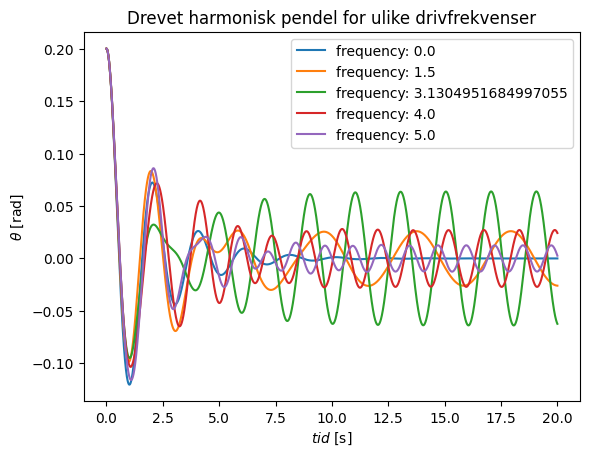

In [25]:
# 3 Ulike drivfrekvenser

freqs = np.array([0,1.5,np.sqrt(g/l),4,5])

for freq in freqs:
    RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, freq, q, drivkraft, dt, T)
    plt.plot(RK4_t[:], RK4_theta, label=f"frequency: {freq}")

plt.title("Drevet harmonisk pendel for ulike drivfrekvenser")
plt.xlabel("$tid$ [s]")
plt.ylabel("$\\theta$ [rad]")
plt.legend()
plt.show()

# 4
I denne oppgaven er det samme som for oppgave 3 gjort bare for friksjonen. Resultatene fra denne testen viser at høyere friksjon fører til lavere resonansamplitude. Vi kan også legge merke til at ved lav nok friksjon, her $0.5$, øker resonansamplituden gradvis helt til den når likevekt. Dette kan være mulig hvis kraften er så stor at den overvinner friksjonen. Ved for høy drivkraft eller for lav friksjon er simulasjonen ustabil eller urealistisk da amplituden vokser uten å tenke på at det ikke gir mening på amplituder som er mye høyere enn $\pi l$. 

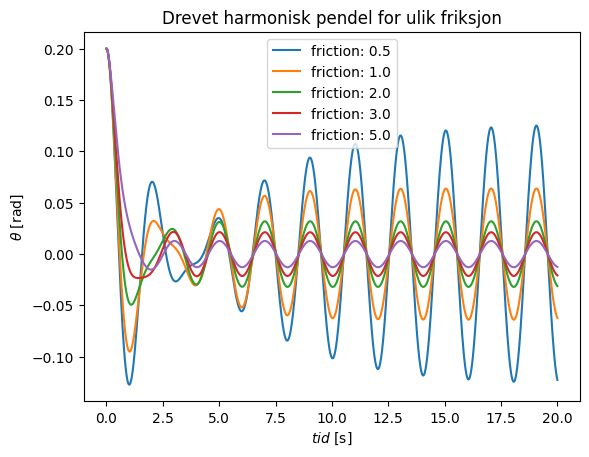

In [137]:
# 4 Undersøk resonansamplituden og friksjon

friction = np.array([0.5, 1, 2, 3, 5])

for fric in friction:
    RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, w_D, fric, drivkraft, dt, T)
    plt.plot(RK4_t[:], RK4_theta, label=f"friction: {fric}")

plt.title("Drevet harmonisk pendel for ulik friksjon")
plt.xlabel("$tid$ [s]")
plt.ylabel("$\\theta$ [rad]")
plt.legend()
plt.show()

# 5
Her har vi satt drivkraften til null og undersøker kritisk, underkritisk og overkritisk demping. Fra resultatene er det kritisk demping ved ca. $q=5.5$, overkritisk demping med $q>5.5$, underkritsik demping med $q<5.5$, og udempet svingning ved q = 0.

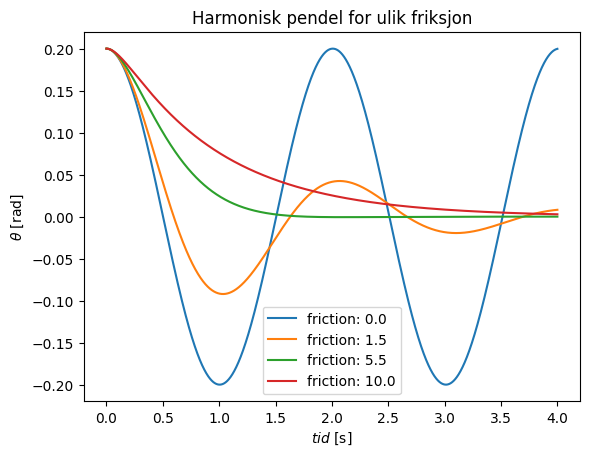

In [27]:
# 5
F_D = 0
T_fric = 4

friction = np.array([0.0, 1.5, 5.5, 10])

for fric in friction:
    RK4_theta, RK4_w, RK4_t = RK4_method(equation, theta_0, theta_dot_0, w_D, fric, F_D, dt, T_fric)
    plt.plot(RK4_t[:], RK4_theta, label=f"friction: {fric}")

plt.title("Harmonisk pendel for ulik friksjon")
plt.xlabel("$tid$ [s]")
plt.ylabel("$\\theta$ [rad]")
plt.legend()
plt.show()

# 6 Uten tilnærming
Her er det gjort likt som i oppgave 1 bare at vi ikke bruker vinkeltilnærmingen $\sin{\theta} = \theta$. Plotet viser vinkelutslaget fra 0 til 20 sekunder med startvinkel på 60 grader.

Vi ser fra plot 2 at approksimasjonen er dårlig for store vinkler, men blir bedre jo mindre vinkelen blir, som gir mening.


Til slutt er det prøvd mange ulike parametre for systemet. I plottet vises det et system med parametre ... Det kan virke som at et sytstem med lav firksjon og høy drivkraft kan vokse ubegrenset, og oppføre seg kaotisk.

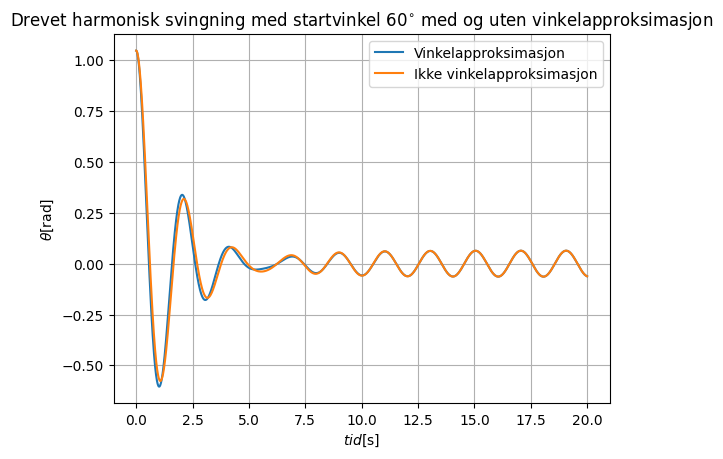

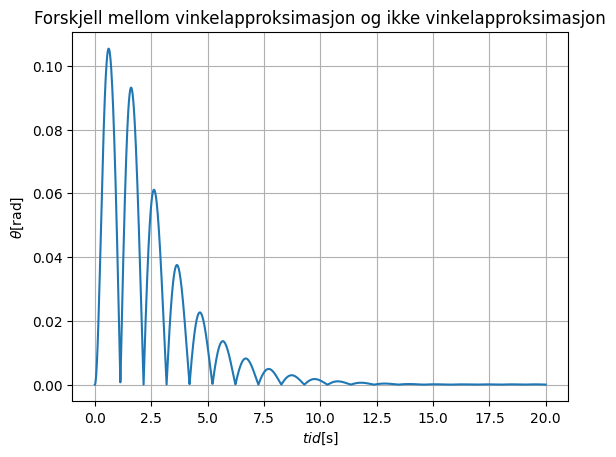

In [22]:
# 6a Uten tilnærming
def equation2(t: float, vals: List[float], params: List[float]):
    dw = -params[1]*vals[1]-g/l*np.sin(vals[0])+params[2]*np.sin(params[0]*t)
    dtheta = vals[1]
    
    return np.array([dtheta, dw])

theta2_0 = np.radians(60)
RK4_theta60, RK4_w60, RK4_t60 = RK4_method(equation, theta2_0, theta_dot_0, w_D, q, drivkraft, 0.01, T)
RK4_theta602, RK4_w602, RK4_t602 = RK4_method(equation2, theta2_0, theta_dot_0, w_D, q, drivkraft, 0.01, T)

plt.plot(RK4_t60, RK4_theta60, label="Vinkelapproksimasjon")
plt.plot(RK4_t602, RK4_theta602, label="Ikke vinkelapproksimasjon")

plt.title("Drevet harmonisk svingning med startvinkel $60^{\\circ}$ med og uten vinkelapproksimasjon")
plt.xlabel("$tid$[s]")
plt.ylabel("$\\theta$[rad]")
plt.legend()
plt.grid()
plt.show()

plt.plot(RK4_t60, np.abs(RK4_theta602-RK4_theta60))
plt.title("Forskjell mellom vinkelapproksimasjon og ikke vinkelapproksimasjon")
plt.xlabel("$tid$[s]")
plt.ylabel("$\\theta$[rad]")
plt.grid()
plt.show()

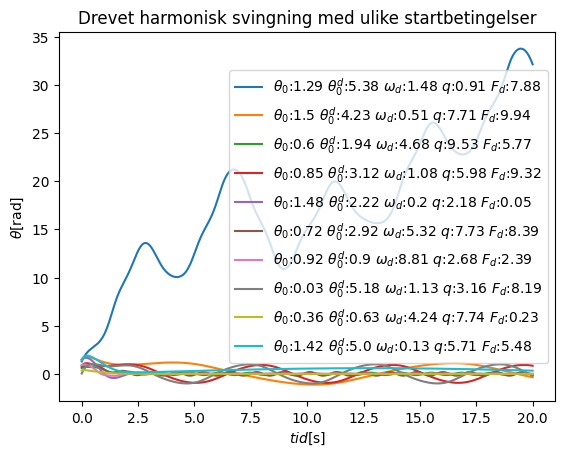

In [140]:
# 6b Utforsking
import random
"""
params: [theta0, theta_dot_0, w_d, q, F_d]
"""
def generate_params():
    thet_0 = round(random.random()*np.radians(90),2)
    thet_dot_0 = round(random.random()*10,2)
    omega_d = round(random.random()*10,2)
    fr = round(random.random()*10,2)
    forc = round(random.random()*10,2)
    return [thet_0, thet_dot_0, omega_d, fr, forc]

params: List[int] = [generate_params() for _ in range(10)]


for param in params:
    RK4_theta2, RK4_w2,RK4_t2 = RK4_method(equation2, param[0], param[1], param[2], param[3], param[4], 0.01, 20)
    plt.plot(RK4_t2, RK4_theta2, label=f"$\\theta_0$:{param[0]} $\\theta_0^d$:{param[1]} $\\omega_d$:{param[2]} $q$:{param[3]} $F_d$:{param[4]}")

plt.title("Drevet harmonisk svingning med ulike startbetingelser")
plt.xlabel("$tid$[s]")
plt.ylabel("$\\theta$[rad]")
plt.legend()
plt.show()